<a href="https://colab.research.google.com/github/beyzoskaya/PyTorch_deepLearning/blob/main/CIFAR10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [80]:
import matplotlib.pyplot as plt
import numpy as np

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [82]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [83]:
from torch._C import TracingState
train_set = torchvision.datasets.CIFAR10(root="./data",
                                         train=True,
                                         download=True,
                                         transform=transform)
test_set = torchvision.datasets.CIFAR10(root="./data",
                                        train=False,
                                        download=True,
                                        transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
len(train_set), len(test_set)

(50000, 10000)

In [85]:
train_set, test_set

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

In [86]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [87]:
class_names = train_set.classes
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

In [88]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [89]:
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [90]:
from typing import Tuple, Dict, List
import random

In [91]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int=None,
                          display_shape: bool=True,
                          seed: int=None):
  if n>10:
    n=10
    display_shape=False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  if seed:
    torch.manual_seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)
  plt.figure(figsize=(12,6))

  for index, target_sample in enumerate(random_samples_idx):
    target_image, target_label = dataset[target_sample]
    target_image = target_image / 2 + 0.5
    target_image_transform = target_image.permute(1,2,0)

    plt.subplot(1,n, index+1)
    plt.imshow(target_image_transform)
    plt.axis(False)
    #if classes:
      #title = f"Class: {classes[target_label]}"
      #if display_shape:
        #title = title + f"\nshape: {target_image_transform.shape}"
    #plt.title(title)

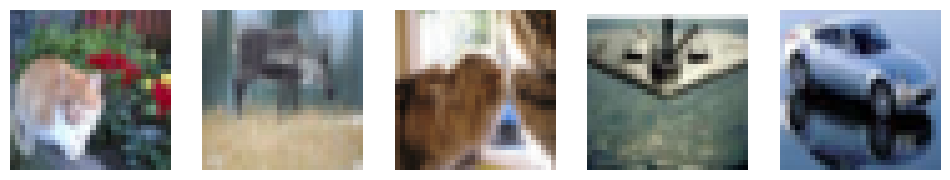

In [92]:
display_random_images(train_set,
                      n=5,
                      classes=class_names,
                      seed=None)

In [93]:
random.sample(range(len(train_set)), k=5)

[37233, 29507, 13798, 28304, 42878]

In [94]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = torch.utils.data.DataLoader(train_set,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_set,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=NUM_WORKERS)

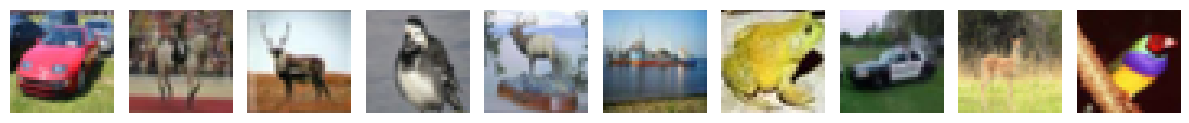

In [95]:
def display_random_images_DataLoader(dataset_loader: torch.utils.data.DataLoader,
                                     classes: List[str] = None,
                                     n: int = None,
                                     display_shape: bool = True,
                                     seed: int = None):
    if n is None:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10. Setting n to 10 and removing shape display.")

    if seed:
        torch.manual_seed(seed)

    dataset = dataset_loader.dataset
    batch_size = dataset_loader.batch_size
    num_samples = len(dataset)
    random_sample_indices = random.sample(range(num_samples), k=n)

    plt.figure(figsize=(12, 6))

    for index, sample_idx in enumerate(random_sample_indices):
        batch_idx = sample_idx // batch_size
        within_batch_idx = sample_idx % batch_size

        batch_data, batch_labels = next(iter(dataset_loader))  # Retrieve the entire batch

        target_image = batch_data[within_batch_idx] / 2 + 0.5
        target_image_transform = target_image.permute(1, 2, 0)

        plt.subplot(1, n, index + 1)
        plt.imshow(target_image_transform)
        plt.axis(False)

    plt.tight_layout()
    plt.show()

# Example usage
display_random_images_DataLoader(train_dataloader, classes=class_names, n=10, seed=None)


In [96]:
len(train_dataloader), len(test_dataloader)

(1563, 313)

In [97]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f9f54364700>, <torch.utils.data.dataloader.DataLoader object at 0x7fa0105c07c0>)
Length of train_dataloader: 1563 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [98]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [ ]:
1563 * 32

50016

In [99]:
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),      # Randomly rotate the image by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Random crop and resize
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [100]:
augmented_train_set = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=augmentation_transform
)

augmented_train_dataloader = torch.utils.data.DataLoader(
    augmented_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

Files already downloaded and verified


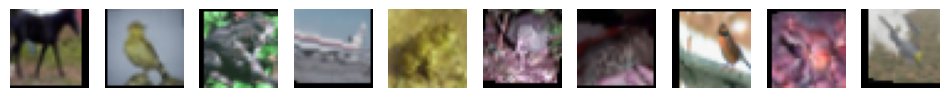

In [101]:
display_random_images(augmented_train_set,
                      n=10,
                      classes=class_names,
                      seed=None)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


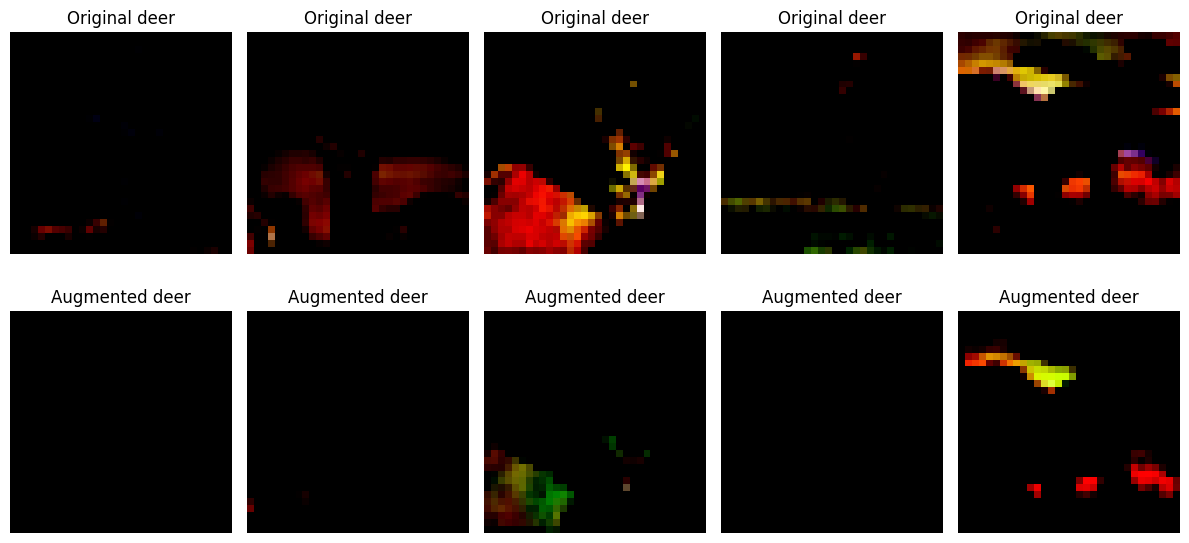

In [102]:
def display_original_and_augmented(dataset: torch.utils.data.Dataset,
                                   class_name: str,
                                   classes: List[str] = None,
                                   n: int = None,
                                   seed: int = None):
    if n is None:
        n = 5

    if seed:
        torch.manual_seed(seed)

    class_idx = class_to_idx[class_name]
    class_samples = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    random_original_samples = random.sample(class_samples, k=n)

    augmentation_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ])


    plt.figure(figsize=(12, 6))

    for index, original_sample in enumerate(random_original_samples):
        original_image, _ = dataset[original_sample]
        augmented_image = augmentation_transform(original_image)


        # Apply ToTensor and Normalize to both original and augmented images
        original_image = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(original_image)

        augmented_image = transforms.Compose([
            augmentation_transform,
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(original_image)

        plt.subplot(2, n, index + 1)
        plt.imshow(original_image.permute(1, 2, 0))
        plt.title(f"Original {class_name}")
        plt.axis('off')

        plt.subplot(2, n, n + index + 1)
        plt.imshow(augmented_image.permute(1, 2, 0))
        plt.title(f"Augmented {class_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
display_original_and_augmented(train_set, class_name='deer', classes=class_names, n=5, seed=None)


In [127]:
import torch
from torch import nn

class Model_0(nn.Module):
  def __init__(self, input_shape:int, hidden_units: int, output_shape:int):
     super(Model_0,self).__init__()

     self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units*2,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units*2,
                  out_channels=hidden_units*4,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU())

     self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units*4,
                  out_channels=hidden_units*8,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units*8,
                  out_channels=hidden_units*16,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=3),
        nn.Dropout(0.5))
     self.classifier = nn.Sequential(
                                    nn.Flatten(),
                                    nn.Linear(in_features=hidden_units * 16*10*10,
                                              out_features=hidden_units*10))

  def forward(self,x):
    x = self.conv_layer_1(x)
    #print(f"Shape after conv layer 1: {x.shape}")
    x = self.conv_layer_2(x)
    #print(f"Shape after conv layer 2: {x.shape}")
    x = self.classifier(x)
    #print(f"Shape after classifier {x.shape}")
    return x

In [128]:
model=Model_0(input_shape=3,
              hidden_units=10,
              output_shape=len(class_names)).to(device)

In [129]:
rand_image = torch.randn(size=(3,32,32))
rand_image.shape

torch.Size([3, 32, 32])

In [130]:
model(rand_image.unsqueeze(0).to(device))

tensor([[-0.0254,  0.0073, -0.0318, -0.0694, -0.0211,  0.0047, -0.0315, -0.0222,
          0.0131, -0.0347,  0.0265,  0.0051, -0.0596, -0.0248,  0.0024,  0.0403,
         -0.0341, -0.0164, -0.0206,  0.0411, -0.0089,  0.0212,  0.0281,  0.0604,
         -0.0334,  0.0074, -0.0074, -0.0004, -0.0054, -0.0570, -0.0269,  0.0254,
          0.0044,  0.0413,  0.0271,  0.0019,  0.0195, -0.0187,  0.0193,  0.0148,
         -0.0160, -0.0209, -0.0233, -0.0043, -0.0236,  0.0680, -0.0016, -0.0146,
          0.0091,  0.0216, -0.0204, -0.0650,  0.0168, -0.0234, -0.0358,  0.0164,
          0.0049, -0.0040,  0.0075, -0.0186, -0.0175,  0.0217, -0.0054,  0.0041,
         -0.0461, -0.0151, -0.0174,  0.0082, -0.0044,  0.0234, -0.0141, -0.0338,
          0.0133, -0.0343,  0.0145,  0.0046,  0.0147, -0.0561, -0.0050,  0.0665,
         -0.0287, -0.0440,  0.0142,  0.0050,  0.0069, -0.0126,  0.0042,  0.0162,
          0.0013, -0.0346, -0.0179, -0.0454, -0.0177,  0.0242,  0.0215, -0.0198,
         -0.0167, -0.0099,  

In [131]:
model

Model_0(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=3, stride=3, padding=0)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16000, out_features=100, bias=True)
  )
)

In [132]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


In [133]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [134]:
from timeit import default_timer as timer
def train_time(start: float,
               end: float,
               device: torch.device=None):
  total_time = end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [136]:
from tqdm.auto import tqdm
torch.manual_seed(42)
epochs = 50
train_time_start_on_cpu = timer()

train_losses = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(epochs)):
  train_loss = 0
  # Training loop
  for batch, (X,y) in enumerate(train_dataloader):
    model.train()
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for batch, (X_test,y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model(X_test)
      #print(f"Test predictions: {test_pred}")
      test_loss += loss_fn(test_pred,y_test)
      #print(f"True value (y_true: {y_pred} | Prediction shapes: {y_pred.shape}")
      #print(f"Prediction: {y_test.argmax(dim=0)} | Shape: {y_test.argmax(dim=0).shape}")
      test_acc += accuracy_fn(y_true=y_test,
                              y_pred=test_pred.argmax(dim=1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  test_accuracies.append(test_acc)

  #print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
  print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}| "
          f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

train_time_end_on_cpu = timer()
total_train_time_model_0 = train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model.parameters()).device))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.44503| Test Loss: 1.41811, Test Acc: 48.63%
Epoch: 1 | Train Loss: 1.36759| Test Loss: 1.27285, Test Acc: 54.30%
Epoch: 2 | Train Loss: 1.23252| Test Loss: 1.17865, Test Acc: 57.60%
Epoch: 3 | Train Loss: 1.14988| Test Loss: 1.14243, Test Acc: 59.24%
Epoch: 4 | Train Loss: 1.09899| Test Loss: 1.13618, Test Acc: 59.67%
Epoch: 5 | Train Loss: 1.05037| Test Loss: 1.07613, Test Acc: 61.54%
Epoch: 6 | Train Loss: 1.00696| Test Loss: 1.03212, Test Acc: 63.47%
Epoch: 7 | Train Loss: 0.97742| Test Loss: 0.99817, Test Acc: 64.76%
Epoch: 8 | Train Loss: 0.93610| Test Loss: 0.95219, Test Acc: 66.29%
Epoch: 9 | Train Loss: 0.90284| Test Loss: 0.96394, Test Acc: 66.12%
Epoch: 10 | Train Loss: 0.87020| Test Loss: 0.89828, Test Acc: 68.35%
Epoch: 11 | Train Loss: 0.83455| Test Loss: 0.88259, Test Acc: 68.96%
Epoch: 12 | Train Loss: 0.80775| Test Loss: 0.87817, Test Acc: 69.20%
Epoch: 13 | Train Loss: 0.77664| Test Loss: 0.85778, Test Acc: 69.91%
Epoch: 14 | Train Loss: 0.7505

In [137]:
train_losses = [loss.detach().numpy() for loss in train_losses]
test_losses = [loss.cpu().numpy() for loss in test_losses]
test_accuracies = [acc.cpu().numpy() for acc in test_accuracies]

plt.figure(figsize=(12, 6))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train')
plt.plot(range(epochs), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(epochs), test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

AttributeError: ignored

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
!pip install tqdm

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [ ]:

epochs = 50

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

class_correct = [0] * len(class_names)
class_total = [0] * len(class_names)

for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for batch_idx, (inputs, labels) in enumerate(train_dataloader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      # print(f"labels: {labels.shape}")
      _, predicted = torch.max(outputs.data, 1)
      # print(f"predicted: {predicted.shape}")
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_loss = running_loss / len(train_dataloader)
  train_acc = 100 * correct / total
  train_losses.append(train_loss)
  train_accuracies.append(train_acc)

  model.eval()
  test_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in test_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      c = (predicted == labels).squeeze()
      for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  test_loss /= len(test_dataloader)
  test_acc = 100 * correct / total
  test_losses.append(test_loss)
  test_accuracies.append(test_acc)

  if epoch % 1 == 0:
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

for i in range(len(class_names)):
    print(f'Accuracy of {class_names[i]:<10}: {100 * class_correct[i] / class_total[i]:.2f}%')

Epoch: 0 | Train Loss: 2.35945, Train Acc: 19.93% | Test Loss: 1.90019, Test Acc: 32.47%
Epoch: 1 | Train Loss: 1.80985, Train Acc: 34.50% | Test Loss: 1.61642, Test Acc: 42.49%
Epoch: 2 | Train Loss: 1.64050, Train Acc: 40.30% | Test Loss: 1.53839, Test Acc: 44.46%
Epoch: 3 | Train Loss: 1.57451, Train Acc: 42.46% | Test Loss: 1.49684, Test Acc: 46.41%
Epoch: 4 | Train Loss: 1.53674, Train Acc: 43.93% | Test Loss: 1.45948, Test Acc: 46.83%
Epoch: 5 | Train Loss: 1.50547, Train Acc: 45.38% | Test Loss: 1.41694, Test Acc: 48.30%
Epoch: 6 | Train Loss: 1.47570, Train Acc: 46.66% | Test Loss: 1.37433, Test Acc: 50.30%
Epoch: 7 | Train Loss: 1.44250, Train Acc: 47.98% | Test Loss: 1.35171, Test Acc: 50.75%
Epoch: 8 | Train Loss: 1.41393, Train Acc: 49.27% | Test Loss: 1.34083, Test Acc: 51.82%
Epoch: 9 | Train Loss: 1.39536, Train Acc: 49.83% | Test Loss: 1.30929, Test Acc: 53.07%
Epoch: 10 | Train Loss: 1.37650, Train Acc: 50.60% | Test Loss: 1.28502, Test Acc: 54.66%
Epoch: 11 | Train Lo

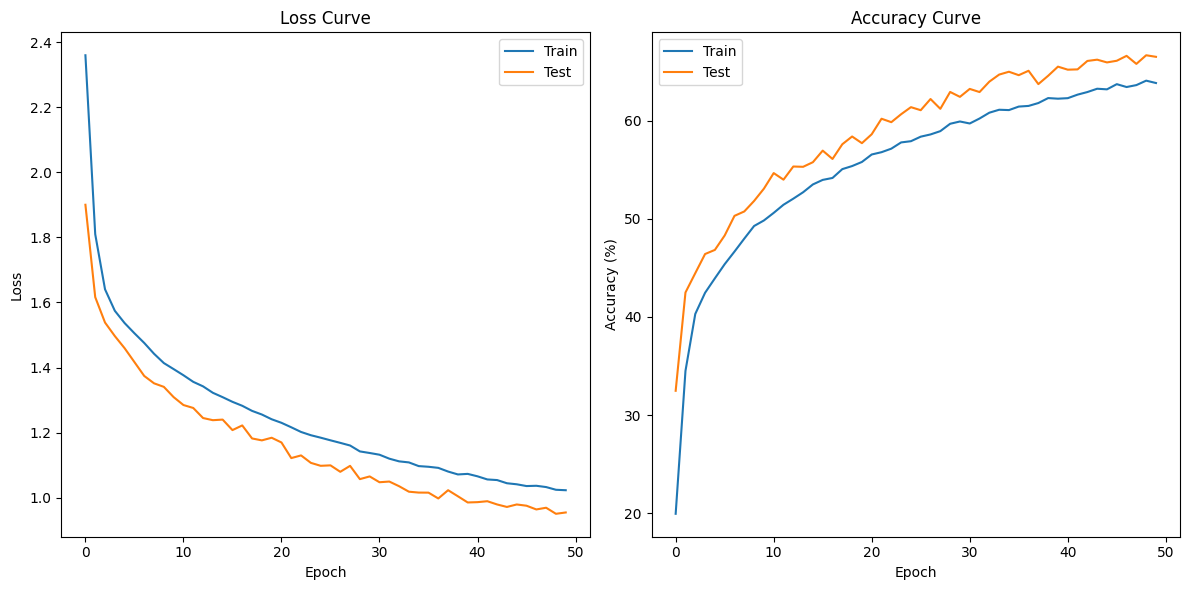

In [ ]:
plt.figure(figsize=(12, 6))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train')
plt.plot(range(epochs), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train')
plt.plot(range(epochs), test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
from torch import nn

class Model_1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(Model_1, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=1, stride=1),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units * 2,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=1, stride=1),
            nn.Conv2d(in_channels=hidden_units * 2,
                      out_channels=hidden_units * 4,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=1, stride=1),
            nn.Conv2d(in_channels=hidden_units * 4,
                      out_channels=hidden_units * 8,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units * 8),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=1, stride=1),
            nn.Conv2d(in_channels=hidden_units * 8,
                      out_channels=hidden_units * 8,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units * 8),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 8192,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # print(x.shape)
        # x = self.conv_layer_2(x)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [ ]:
model_1=Model_1(input_shape=3,
              hidden_units=64,
              output_shape=len(class_names)).to(device)

In [ ]:
epochs = 50

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

class_correct = [0] * len(class_names)
class_total = [0] * len(class_names)

for epoch in range(epochs):
  model_1.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for batch_idx, (inputs, labels) in enumerate(train_dataloader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model_1(inputs)
      # print(f"labels: {labels.shape}")
      _, predicted = torch.max(outputs.data, 1)
      # print(f"predicted: {predicted.shape}")
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_loss = running_loss / len(train_dataloader)
  train_acc = 100 * correct / total
  train_losses.append(train_loss)
  train_accuracies.append(train_acc)

  model_1.eval()
  test_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in test_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model_1(inputs)
      loss = criterion(outputs, labels)
      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      c = (predicted == labels).squeeze()
      for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  test_loss /= len(test_dataloader)
  test_acc = 100 * correct / total
  test_losses.append(test_loss)
  test_accuracies.append(test_acc)

  if epoch % 1 == 0:
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

for i in range(len(class_names)):
    print(f'Accuracy of {class_names[i]:<10}: {100 * class_correct[i] / class_total[i]:.2f}%')

Epoch: 0 | Train Loss: 2.36787, Train Acc: 9.91% | Test Loss: 2.37421, Test Acc: 9.66%
Epoch: 1 | Train Loss: 2.36895, Train Acc: 9.86% | Test Loss: 2.37781, Test Acc: 9.78%


KeyboardInterrupt: ignored

In [ ]:
import math
524288 / 32

16384.0

In [ ]:
plt.figure(figsize=(12, 6))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train')
plt.plot(range(epochs), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train')
plt.plot(range(epochs), test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()